## Part 1: 
Load data, clean, and save aggregate data

In [1]:
import pandas as pd 
import os
import numpy as np
from data_cleaning import change_columns_types
from data_loading import aggregate_data
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#immport necessary libraries and filter warnings
import warnings


from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import nfl_data_py as nfl
from sklearn.impute import SimpleImputer
from utility_db_25 import mark_columns, TrainML, build_catboost, optuna_call, test_ML, build_transformer, get_final_features
warnings.filterwarnings("ignore")

In [6]:
root_dir = os.getcwd()

load_saved_data = False       # if you change this to true you can load presaved data

if not load_saved_data: 
    games_fname= os.path.join(root_dir, "data/games.csv")
    plays_fname = os.path.join(root_dir,  "data/plays.csv")
    players_fname = os.path.join(root_dir,  "data/players.csv")
    player_plays_fname = os.path.join(root_dir,  "data/player_play.csv")
    xp_fname = os.path.join(root_dir, "data/team_xpass_ratios.csv")
    pr_fname = os.path.join(root_dir, "data/team_pass_rates.csv")
    cf_fname = os.path.join(root_dir, "data/coverages_faced.csv")
    cu_fname = os.path.join(root_dir, 'data/coverages_used.csv')
    inj_fname = os.path.join(root_dir, 'data/snaps_lost_injury.csv')
    tracking_fname_list_train = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,9)] #weeks 1-8 are training data
    tracking_fname_list_test = [os.path.join(root_dir,  "data/tracking_week_9.csv")] #week 9 is test data
    train_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_train, games_fname, xp_fname, pr_fname, cf_fname, cu_fname,inj_fname)
    train_data.to_csv(os.path.join(root_dir, "data/train_data.csv"), index=False)
    test_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_test, games_fname, xp_fname, pr_fname, cf_fname, cu_fname,inj_fname)
    test_data.to_csv(os.path.join(root_dir, "data/test_data.csv"), index=False)
else:
    train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
    test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
print('train colums: ', len(train_data.columns))
print('test colums: ', len(test_data.columns))

2022 done.
Downcasting floats.
INFO: Labeling plays as runs or passes
2022 done.
Downcasting floats.
Downcasting floats.
2022 done.
Downcasting floats.
INFO: Labeling plays as runs or passes
2022 done.
Downcasting floats.
Downcasting floats.
train colums:  440
test colums:  370


In [7]:
include_columns=test_data.columns
train_data=train_data[include_columns]
train_data.columns

Index(['gameId', 'playId', 'quarter', 'down', 'yardsToGo',
       'score_differential', 'time_remaining', 'playNullifiedByPenalty',
       'preSnapHomeTeamWinProbability', 'pass_rush_ratio',
       ...
       'cover_6_def', 'cover_1_def', 'Quarters_def', 'Cover-2_def',
       'Cover-0_def', 'Man_def', 'Other_def', 'Zone_def', 'off_snaps_lost',
       'def_snaps_lost'],
      dtype='object', length=370)

In [8]:
[x for x in train_data.columns if 'snaps_lost' in x]

['off_snaps_lost', 'def_snaps_lost']

## Goal: 
To predict pass attempts for each play with greater accuracy and precision than the baseline dummy classifier. The base rate is about 60%. We will look at the offensive players' tracking data, along with characteristics of the play including the offensive formation and receiver alignment.

## General Strategy:
1. Read all data
2. Merge data
3. Filter data for offensive players, plays not nullified by a penalty, and data before the snap
4. Create a target variable 'pass' to indicate if a pass was attempted
5. Feature engineering and feature selection
6. Test baseline models
7. Tune models

In [9]:

for col in train_data.columns: 
    if round((train_data[col].isna().sum() /len(train_data)*100), 2)>75:
        train_data.drop(columns=col, inplace=True)
    elif round((train_data[col].isna().sum() /len(train_data)*100), 2)>0:
        print(col,round((train_data[col].isna().sum() /len(train_data)*100), 2), '% missing')
    else: 
        print(col)

gameId
playId
quarter
down
yardsToGo
score_differential
time_remaining 0.81 % missing
playNullifiedByPenalty
preSnapHomeTeamWinProbability
pass_rush_ratio 2.84 % missing
Rain
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing
preSnapVisitorTeamWinProbability
absoluteYardlineNumber
pass
s|max|C_1
s|max|C_2
s|max|FB_1
s|max|G_1
s|max|G_2
s|max|G_3
s|max|ILB_1
s|max|QB_1
s|max|QB_2
s|max|RB_1
s|max|RB_2
s|max|TE_1
s|max|TE_2
s|max|TE_3
s|max|T_1
s|max|T_2
s|max|T_3
s|max|T_4
s|max|WR_1
s|max|WR_2
s|max|WR_3
s|max|WR_4
s|max|WR_5
a|max|C_1
a|max|C_2
a|max|FB_1
a|max|G_1
a|max|G_2
a|max|G_3
a|max|ILB_1
a|max|QB_1
a|max|QB_2
a|max|RB_1
a|max|RB_2
a|max|TE_1
a|max|TE_2
a|max|TE_3
a|max|T_1
a|max|T_2
a|max|T_3
a|max|T_4
a|max|WR_1
a|max|WR_2
a|max|WR_3
a|max|WR_4
a|max|WR_5
o_standard|mean|C_1
o_standard|mean|C_2
o_standard|mean|FB_1
o_standard|mean|G_1
o_standard|mean|G_2
o_standard|mean|G_3
o_standard|mean|ILB_1
o_standard|mean|QB_1
o_standard|mean|QB_2
o_standard|mean|RB_1
o_st

In [10]:
len(train_data.columns)

370

In [11]:
train_data=change_columns_types(train_data)
test_data=change_columns_types(test_data)

In [12]:
final_features=get_final_features(train_data,threshold=.5,trim_rows=0)

In [13]:
len(final_features)

62

In [14]:
numeric_columns, cat_columns = mark_columns(df=train_data,features=final_features, nc=None,cc = None)

<Axes: title={'center': 'Correlation Heatmap of Features'}>

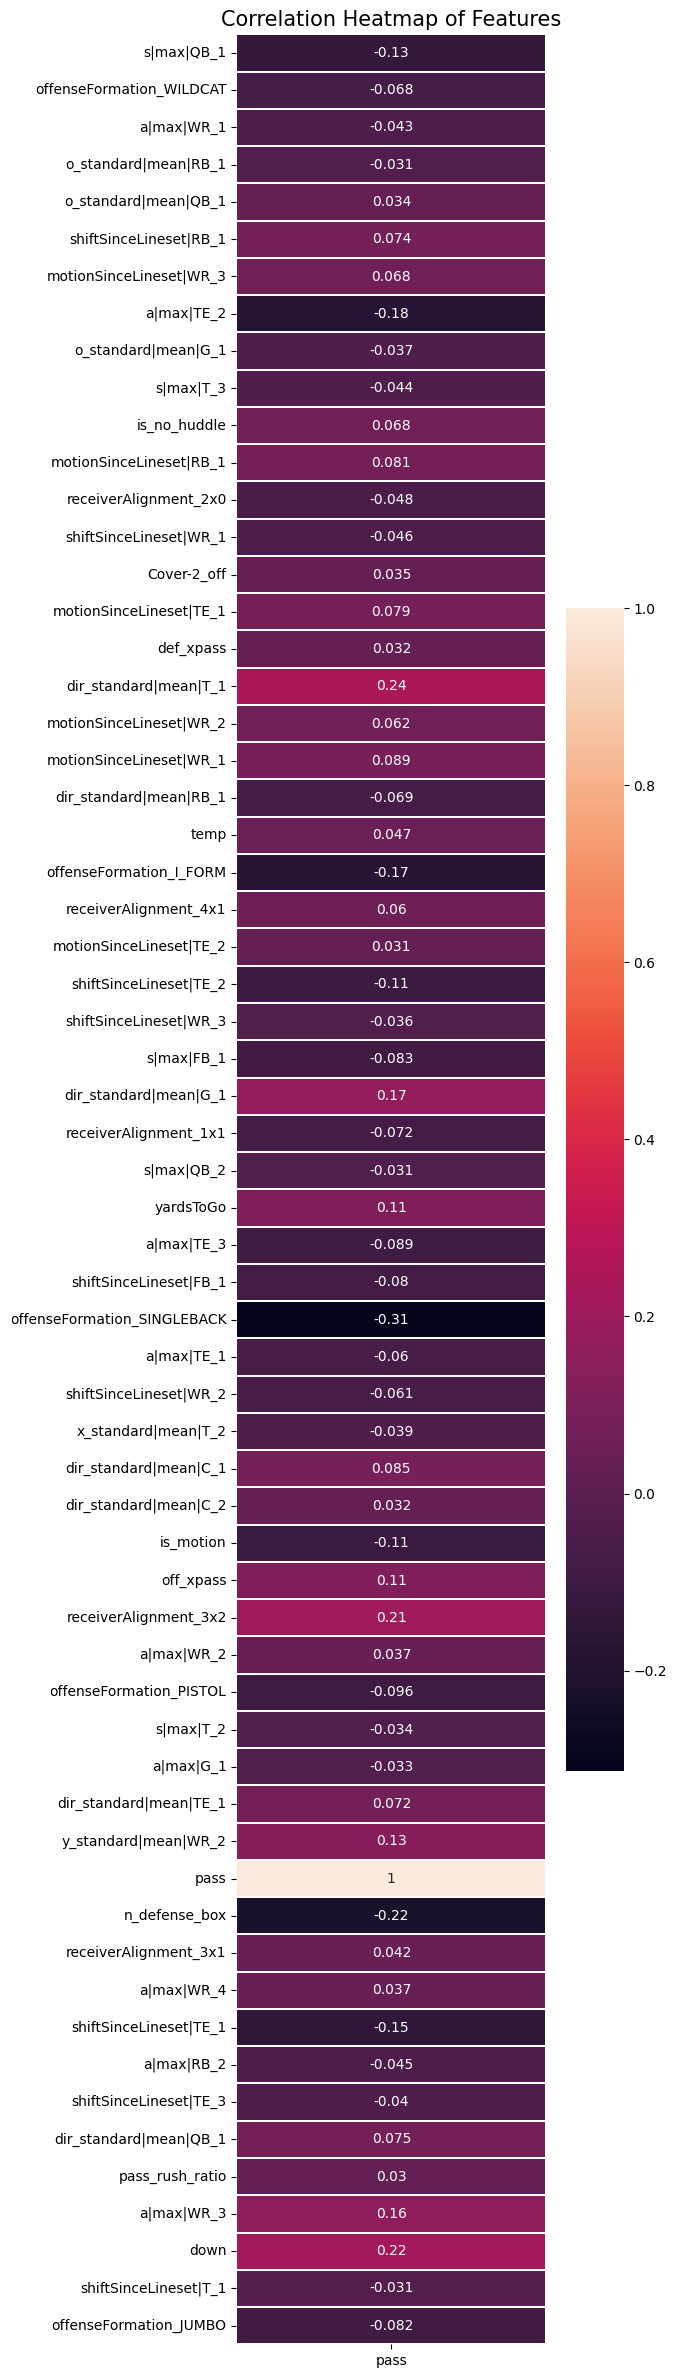

In [15]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,30))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(train_data[final_features].corr()[['pass']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

In [16]:
# Create an imputer object with mean strategy
#imputer = SimpleImputer(strategy='mean')
from sklearn.compose import ColumnTransformer

# Fit and transform the data
#merged_pivot[numeric_columns] = imputer.fit_transform(merged_pivot[numeric_columns])
imputer = SimpleImputer(missing_values = np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns),('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [17]:
#create a function to train ML models and return ROC_AUC and accuracy scores
SEED=42
n_splits=5
#X=merged_pivot[selected_features]
X=train_data[final_features].drop(columns='pass')

y=train_data['pass']

Training Folds: 100%|██████████| 5/5 [00:00<00:00, 29.14it/s]


Mean Train AUC --> 0.5000
Mean Validation AUC ---> 0.5000
Mean Train Accuracy --> 0.6046
Mean Validation Accuracy ---> 0.6046


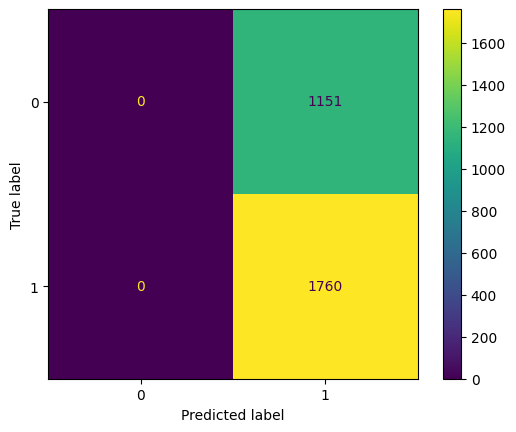

In [18]:
#get baseline value from dummy classifier
dummypipeline=Pipeline([('tr', transformer), ('dummy', DummyClassifier(strategy="most_frequent"))], verbose = True)
TrainML(dummypipeline,X, y, n_splits,SEED)

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

Mean Train AUC --> 0.8766
Mean Validation AUC ---> 0.7775
Mean Train Accuracy --> 0.8829
Mean Validation Accuracy ---> 0.7891


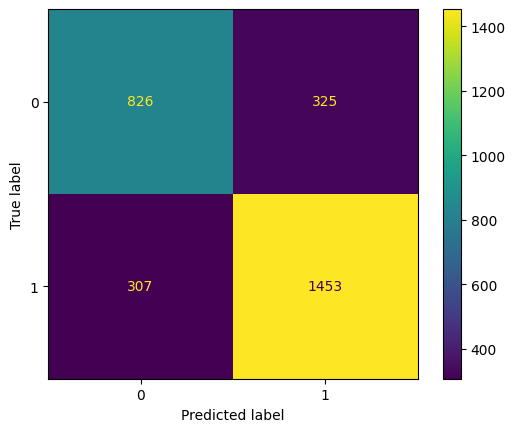

In [19]:
#lgbm classifier
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
TrainML(pipeline,X, y,n_splits,SEED)

Training Folds: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

Mean Train AUC --> 0.8876
Mean Validation AUC ---> 0.7790
Mean Train Accuracy --> 0.8952
Mean Validation Accuracy ---> 0.7916


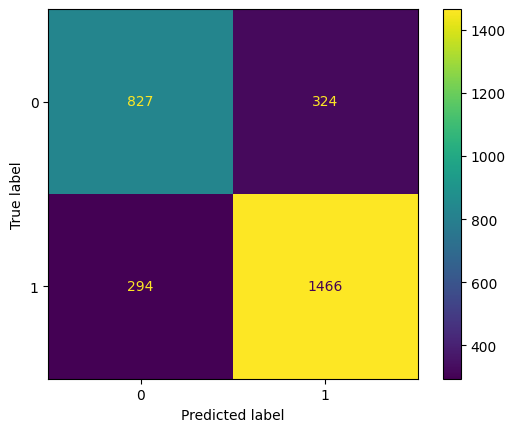

In [20]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  verbose=False))], verbose = True)
TrainML(pipeline,X, y,n_splits,SEED)

In [21]:
final_features.remove('pass')

In [22]:
[x for x in numeric_columns if 'FB' in x]

['s|max|FB_1']

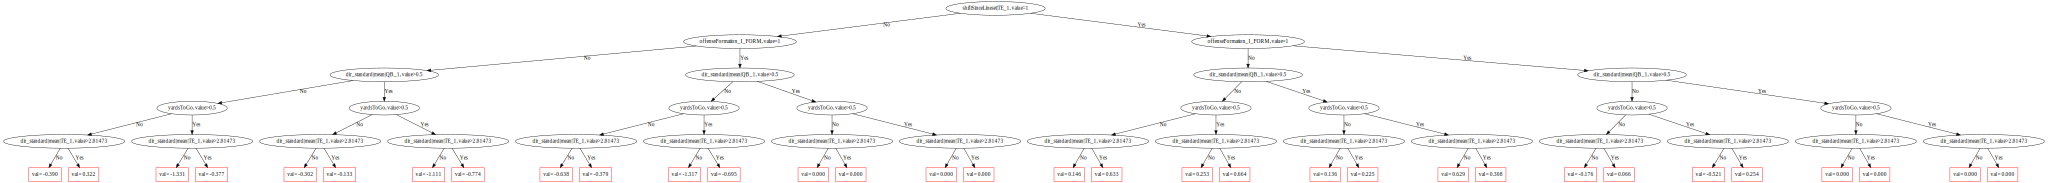

In [23]:
from catboost import  Pool, MetricVisualizer
import ipywidgets as widgets
%matplotlib inline
#need graphviz for this part and to add to path https://graphviz.org/download/

# For explicitly displaying widgets
from IPython.display import display

model, pool, cat_features_index, X_transform = build_catboost(final_features, train_data, imputer, {'max_depth':5,'iterations':2})


model.plot_tree(
    tree_idx=1,
    pool=pool
)

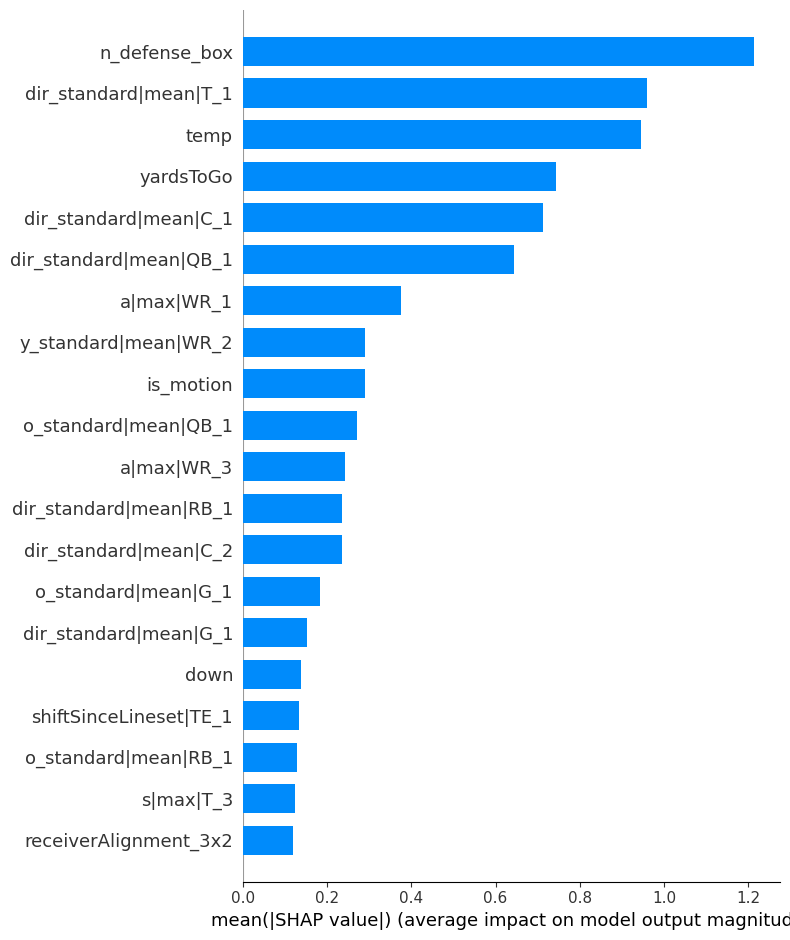

In [24]:
import shap
model = CatBoostClassifier( 
    verbose=False).fit(pool)
shap_values = model.get_feature_importance(Pool(X, label=y, cat_features=cat_features_index),type="ShapValues")
shap_values = shap_values[:, :-1]
shap.summary_plot(shap_values, X, plot_type="bar")

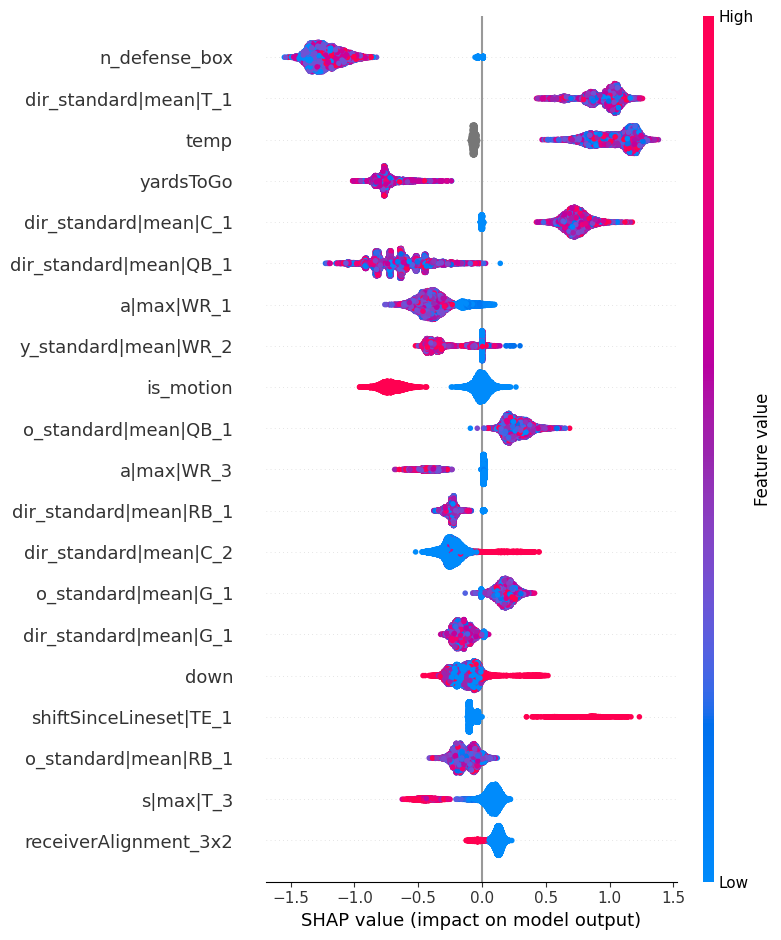

In [25]:
shap.summary_plot(shap_values, X)

In [26]:
importances =model.get_feature_importance(type='PredictionValuesChange')
feature_importances=pd.Series(importances, index=X.columns).sort_values()
feature_importance_df=pd.DataFrame(feature_importances, columns=[ 'importance']).sort_values('importance', ascending=False)
selected_features=list(feature_importance_df.head(len(final_features)).T.columns)
top_30_features=list(feature_importance_df.head(30).T.columns)
top_30_features


['receiverAlignment_1x1',
 'dir_standard|mean|QB_1',
 'down',
 'is_motion',
 'o_standard|mean|QB_1',
 'x_standard|mean|T_2',
 'dir_standard|mean|TE_1',
 'dir_standard|mean|C_2',
 'off_xpass',
 's|max|QB_1',
 'def_xpass',
 'shiftSinceLineset|TE_1',
 'a|max|WR_2',
 'a|max|RB_2',
 'Cover-2_off',
 's|max|T_2',
 'a|max|G_1',
 'a|max|WR_1',
 'offenseFormation_SINGLEBACK',
 'yardsToGo',
 'receiverAlignment_3x2',
 's|max|T_3',
 'temp',
 'pass_rush_ratio',
 'dir_standard|mean|T_1',
 'shiftSinceLineset|FB_1',
 'offenseFormation_I_FORM',
 'shiftSinceLineset|WR_2',
 'receiverAlignment_4x1',
 'o_standard|mean|RB_1']

In [27]:
final_numeric_columns, final_cat_columns = mark_columns(df=train_data,features=final_features, nc=numeric_columns,cc = cat_columns)

In [28]:
from sklearn.compose import ColumnTransformer
# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, final_numeric_columns),
        ('scaler', MinMaxScaler(), final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [29]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
X=train_data[final_features]

y=train_data['pass']
# Define the helper function so that it can be reused

cat_params = optuna_call(transformer,X,y,SKF,n_trials=20)

[I 2024-10-27 08:10:11,489] A new study created in memory with name: no-name-26595dcb-4b8d-4386-a276-50b22cc67b4a


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-10-27 08:10:31,726] Trial 0 finished with value: 0.7846930551413547 and parameters: {'learning_rate': 0.061151609509839125, 'depth': 8, 'subsample': 0.3245362688173392, 'colsample_bylevel': 0.6326966658710466, 'iterations': 286}. Best is trial 0 with value: 0.7846930551413547.
[I 2024-10-27 08:10:58,618] Trial 1 finished with value: 0.786616863469749 and parameters: {'learning_rate': 0.0710732912140322, 'depth': 7, 'subsample': 0.30842338933262575, 'colsample_bylevel': 0.9497354191878327, 'iterations': 478}. Best is trial 1 with value: 0.786616863469749.
[I 2024-10-27 08:11:33,659] Trial 2 finished with value: 0.7880594306929758 and parameters: {'learning_rate': 0.0947621241974044, 'depth': 8, 'subsample': 0.4657987684458618, 'colsample_bylevel': 0.9277267326688041, 'iterations': 417}. Best is trial 2 with value: 0.7880594306929758.
[I 2024-10-27 08:12:02,311] Trial 3 finished with value: 0.7923188521372135 and parameters: {'learning_rate': 0.05321649958605651, 'depth': 8, 'sub

In [30]:
cat_params= {'learning_rate': 0.051007364174007155, 'depth': 7, 'subsample': 0.9376066132270129, 'colsample_bylevel': 0.9446372395814122, 'iterations': 497}

Training Folds: 100%|██████████| 5/5 [00:27<00:00,  5.44s/it]

Mean Train AUC --> 0.9119
Mean Validation AUC ---> 0.7819
Mean Train Accuracy --> 0.9189
Mean Validation Accuracy ---> 0.7945


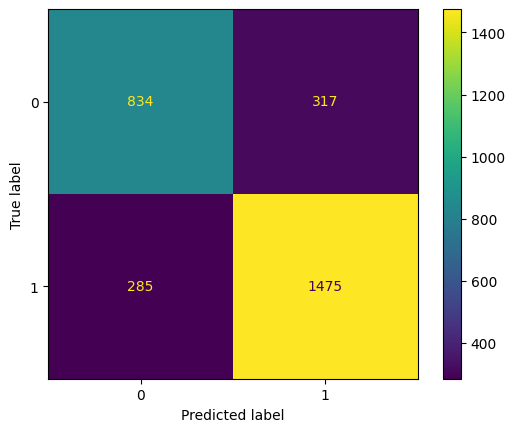

In [31]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  **cat_params, verbose=False))], verbose = True)
TrainML(pipeline,X, y,n_splits,SEED)

In [32]:
from catboost import CatBoost
transformer_impute = build_transformer(imputer,numeric_columns,kind='imputer')
transformer_scale = build_transformer(imputer,numeric_columns,kind='scaler')

X=train_data[final_features]

y=train_data['pass']
numeric_columns=[]
is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna(0, inplace=True)
        X[feature].replace([np.inf, -np.inf], 0, inplace=True)
    else:
        numeric_columns.append(feature)

X_transform=transformer_impute.fit_transform(X)

X_transform = pd.DataFrame(X_transform, columns=final_features)

X_transform=transformer_scale.fit_transform(X_transform)

X_transform = pd.DataFrame(X_transform, columns=final_features)

for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X_transform[feature].fillna(0, inplace=True)
        X_transform[feature].replace([np.inf, -np.inf], 0, inplace=True)
        X_transform[feature]=X_transform[feature].astype(int)

cat_features_index = np.where(is_cat)[0]
pool = Pool(X_transform, y, cat_features=cat_features_index, feature_names=list(X_transform.columns))




model = CatBoostClassifier( **cat_params, verbose=False).fit(pool)



In [33]:
from catboost import Pool, cv
cv_dataset = Pool(data=X_transform,
                  label=y,
                  cat_features=cat_features_index)


params = {"iterations": 497,
          "depth": 7,
          "learning_rate":     0.051007364174007155,
          "subsample": 0.9376066132270129,
            "colsample_bylevel":0.9446372395814122,
          "loss_function": "Logloss",
          "eval_metric":'Accuracy',
          "verbose": False}

scores = cv(cv_dataset,
            params,
            fold_count=5,
            
            plot="True")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7757554945
bestIteration = 400

Training on fold [1/5]

bestTest = 0.7880453452
bestIteration = 471

Training on fold [2/5]

bestTest = 0.7708691171
bestIteration = 490

Training on fold [3/5]

bestTest = 0.7935417382
bestIteration = 483

Training on fold [4/5]

bestTest = 0.8021298523
bestIteration = 473



0.7849004911268738


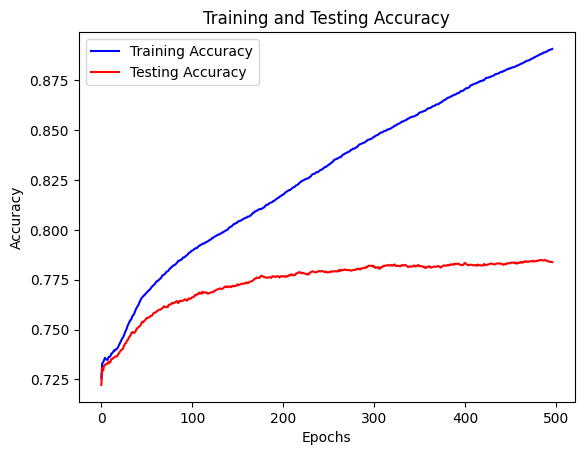

In [34]:
scores
# Plot the accuracy curves
plt.plot(scores['iterations'], scores['train-Accuracy-mean'], 'b', label='Training Accuracy')
plt.plot(scores['iterations'], scores['test-Accuracy-mean'], 'r', label='Testing Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

# Display the pl
print(scores['test-Accuracy-mean'].max())

AUC --> 0.7971818504076569
Accuracy --> 0.8143790849673203


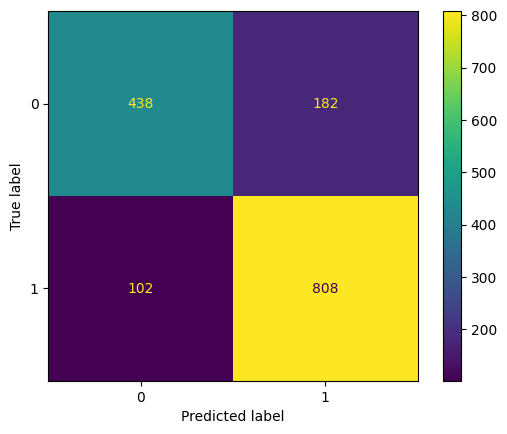

In [35]:
test_ML(test_data, model,final_features,transformer_impute,transformer_scale)

In [36]:
len(final_features)

61